In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'open-images-bus-trucks:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F679312%2F1193394%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240914%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240914T172646Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8670fe84f418546da16448cb6ff2304daa942a3d0471c5b1426043b61f059b6462ef692db35edd553c09774dcb23283c59ef8423135f295688e285be15fe45beb1db0744f1c2d01152b9de2fb4acd91a8bb2dcb5808ba13f0b55df9eaea8ae4a3c79aa8bcf1c069201c1aa6deae39da6e03925449605dc9be8c5af1287d29909b5ce53f650added6df4971fc061fac526631f9de37438814198a41d53800b96b24a6f2ec88a91b5e943aa4c201161985574cd9d2a39c4932de6cb230688aeb243faf09518b2fa46ef81426850bd2b7174710054cc1a88aa75695e3d2b60b953c86c52113bd185109921dab2e6452e0cc2e7443063f0a2a0fa33a0e4c71b17d2c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[=============                                     ] 101867520 bytes downloaded

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

[==================================================] 384594773 bytes downloaded
Downloaded and uncompressed: open-images-bus-trucks
Data source import complete.


# <b>1 <span style ='color:#0386f7de'>|</span> Importing Libraries</b>
- The code below runs RCNN on a dataset of cars and objects from Kaggle
- Dataset is reduced to 100 images for computation purposes

In [2]:
# !pip install -q --upgrade selectivesearch torch_snippets
!pip install selectivesearch
!pip install torch_snippets==0.5


In [3]:
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import numpy as np

# <b>2 <span style ='color:#0386f7de'>|</span> Loading the data</b>

In [4]:
IMAGE_ROOT = '../input/open-images-bus-trucks/images/images'
DF_RAW = pd.read_csv('../input/open-images-bus-trucks/df.csv')
print(DF_RAW.head())

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [29]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # convert BGR to RGB
        # x[...]
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #boxes
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)


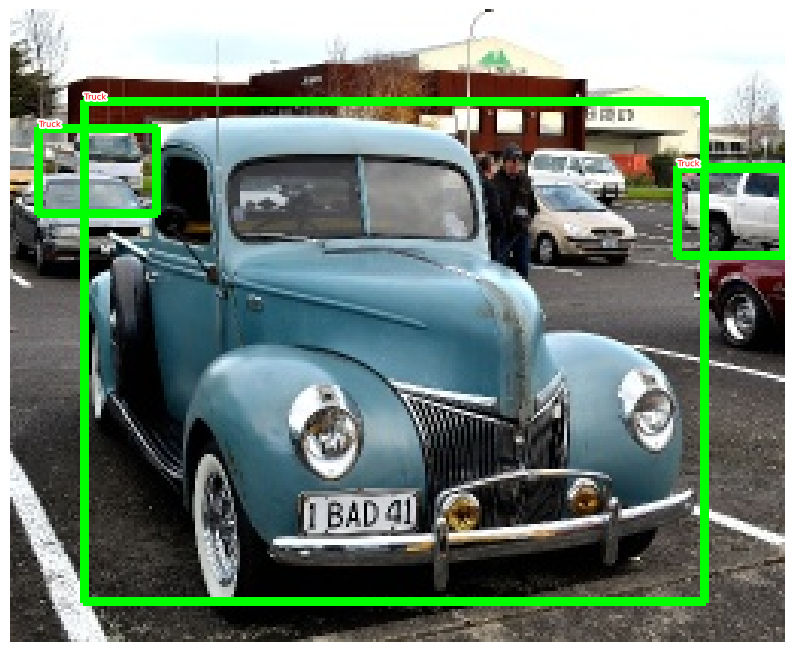

[[9, 39, 48, 67], [24, 30, 229, 195], [220, 52, 255, 81]]

In [6]:
im, bbs, clss, _ = ds[6]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

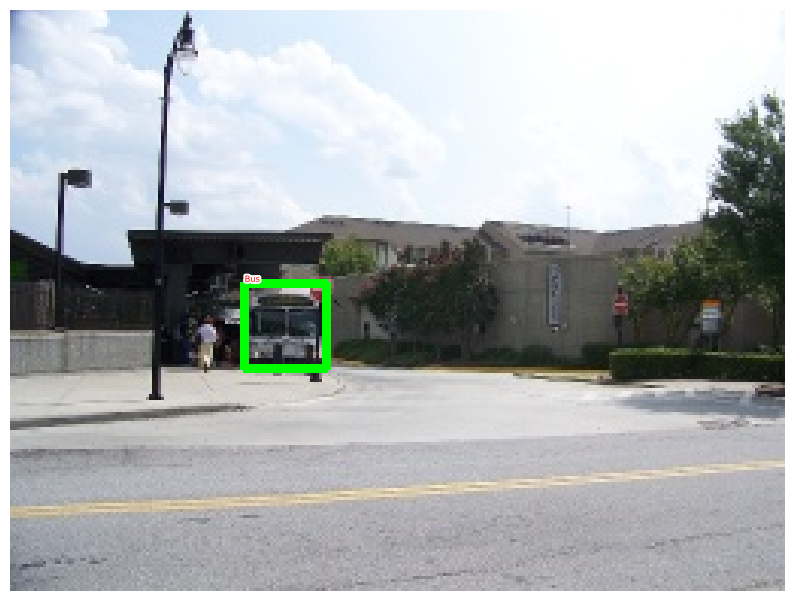

[[77, 90, 104, 118]]

In [7]:
im, bbs, clss, _ = ds[15]
show(im, bbs=bbs, texts=clss, sz=10)
print(bbs)

# <b>3.1 <span style ='color:#0386f7de'>|</span> Building the model</b>
- Region proposals: Code below applies selective search to images, and determines iou of boxes, and applies a loss function

In [8]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

#iou
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)  #change in x-direction
    height = (y2 - y1)  #change in y-direction
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height # this was calculated by x1, y1, x2, y2
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(38, 4)

<class 'list'>

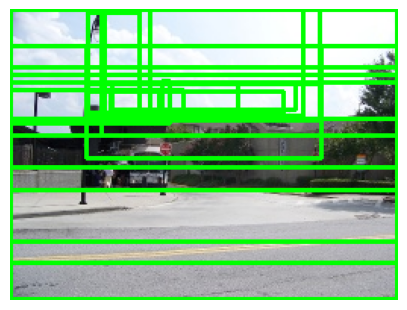

In [9]:
# Example of df[15]
candidates = extract_candidates(im)
print(np.shape(candidates))
print(type(candidates))
show(im, bbs = candidates)

In [10]:
help(show)

Help on function show in module torch_snippets.loader:

show(img=None, ax=None, title=None, sz=None, bbs=None, confs=None, texts=None, bb_colors=None, cmap='gray', grid=False, save_path=None, text_sz=None, df=None, pts=None, conns=None, **kwargs)
    show an image



In [11]:
print(ds[15])

(
    array([[[ 95, 111, 162],
        [112, 128, 177],
        [131, 145, 190],
        ...,
        [254, 255, 255],
        [249, 252, 255],
        [243, 246, 251]],

       [[108, 124, 173],
        [127, 144, 190],
        [148, 163, 206],
        ...,
        [254, 255, 255],
        [248, 251, 255],
        [243, 246, 251]],

       [[117, 134, 178],
        [136, 153, 196],
        [159, 174, 213],
        ...,
        [254, 255, 255],
        [248, 251, 255],
        [243, 248, 252]],

       ...,

       [[111, 115, 126],
        [103, 107, 118],
        [118, 122, 133],
        ...,
        [145, 145, 147],
        [163, 162, 167],
        [156, 155, 160]],

       [[125, 129, 140],
        [107, 111, 122],
        [120, 124, 135],
        ...,
        [166, 164, 165],
        [158, 156, 159],
        [175, 173, 176]],

       [[109, 113, 124],
        [107, 111, 122],
        [121, 125, 136],
        ...,
        [185, 183, 184],
        [163, 161, 164],
        [179, 177, 180]]], dtype=uint8),
    [[77, 90, 104, 118]],
    ['Bus'],
    '../input/open-images-bus-trucks/images/images/0009b74be294a699.jpg'
)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Best IoU: 0.14555256036666817

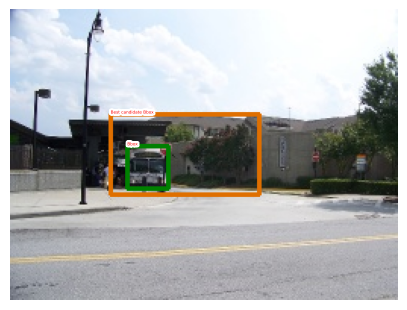

In [12]:

(im, bbs, labels, fpath) = ds[15]
H, W, _ = im.shape
candidates = extract_candidates(im)
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])  # candidates extracted are the x,y,w,h way and made x1, y1, x2, y2 to be similar to the bbs in the dataset

ious, rois, clss, deltas, best_ious = [], [], [], [], []
temp_best_bbs = []
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

for jx, candidate in enumerate(candidates):
    cx,cy,cX,cY = candidate
    candidate_ious = ious[jx]  #ious for that candidate
    best_iou_at = np.argmax(candidate_ious)  #best candidate iou is taken (index) ~ always be a zero index
    best_iou = candidate_ious[best_iou_at]   #gets the best score here
    best_ious.append(best_iou)
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at] # gets the target label bounding box where there is the highest iou
    temp_best_bbs.append(best_bb)
    if best_iou > 0.3: clss.append(labels[best_iou_at]) # if iou is more than 0.3 it is not the background
    else : clss.append('background')
    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])  #normalizing the delta based on image size
    deltas.append(delta)
    rois.append(candidate / np.array([W,H,W,H]))

best_ious_at = np.argmax(best_ious)
print("Best IoU:", best_ious[best_ious_at])


best_candidate = candidates[best_ious_at]
best_bbs = temp_best_bbs[best_ious_at]

# Example of df[15]
candidates = extract_candidates(im)
show(im, bbs = [best_bbs, best_candidate], confs= [0,0.5], texts = ['Bbox', 'Best candidate Bbox'])

In [13]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # if iou is more than 0.3 it is not the background
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]] #?

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3

In [14]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']



print("The label to target values dictionary formed is:" ,label2target)

The label to target values dictionary formed is:
{'Bus': 0, 'background': 1, 'Truck': 2}

In [15]:
# normalizing with the mean, std used while training the model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [30]:
num_samples = 100
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        if num_samples:
            self.fpaths = self.fpaths[:num_samples]
            self.gtbbs = self.gtbbs[:num_samples]
            self.rois = self.rois[:num_samples]
            self.labels = self.labels[:num_samples]
            self.deltas = self.deltas[:num_samples]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]  # bounding box image crops
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        '''Performing actions on a batch of images'''
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [17]:
n_train = 9*len(FPATHS)//10 # 0.9 is the train size
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [18]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False #not to do a re-train
vgg_backbone.eval().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# <b>3.2 <span style ='color:#0386f7de'>|</span> Building the model</b>
R-CNN Convolutional Neural Network architecture
1. Define a VGG backbone.
2. Fetch the features post passing the normalized crop through a pretrained model.
3. Attach a linear layer with sigmoid activation to the VGG backbone to predict the class corresponding to the region proposal.
4. Attach an additional linear layer to predict the four bounding box offsets.
5. Define the loss calculations for each of the two outputs (one to predict class and the other to predict the four bounding box offsets).
6. Train the model that predicts both the class of region proposal and the four bounding box offsets.

In [31]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss() # loss for classification
        self.sl1 = nn.L1Loss() # loss for regression
    def forward(self, input):
        feat = self.backbone(input)  # both classification and regression takes 'feat' as input
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 1) #removing the label 1 (background)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            # every ix is detected as background
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [20]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)  # as model outputs we will be getting classes and delta (bbox offsets)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [21]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)  # more like a softmax np argmax
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [22]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs) #records the metrics as report, can be used to plot later

# <b>4 <span style ='color:#0386f7de'>|</span> Training the model</b>

In [23]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        # Training step
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        _clss, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                   val_regr_loss=regr_loss, val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics


<ipython-input-16-73352c231880>:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.943  val_loc_loss: 0.506  val_regr_loss: 0.144  val_acc: 0.830  (2989.70s - 0.00s remaining)

# <b>5 <span style ='color:#0386f7de'>|</span> Model results</b>

100%|██████████| 106/106 [00:00<00:00, 32487.85it/s]


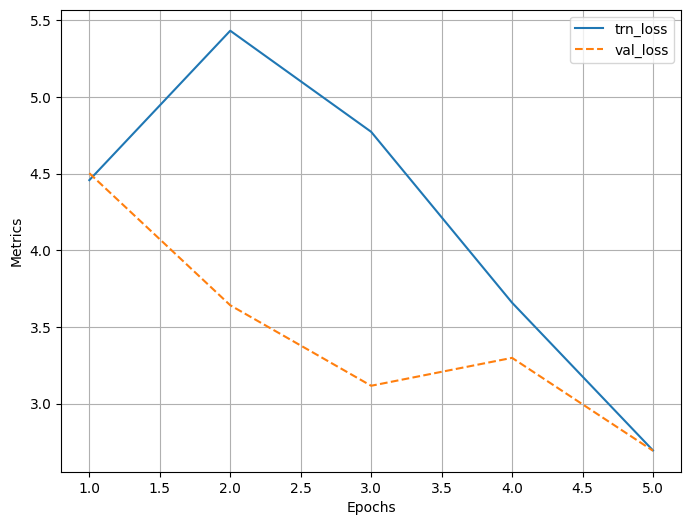

In [24]:
log.plot_epochs('trn_loss,val_loss'.split(','))

100%|██████████| 106/106 [00:00<00:00, 23763.76it/s]


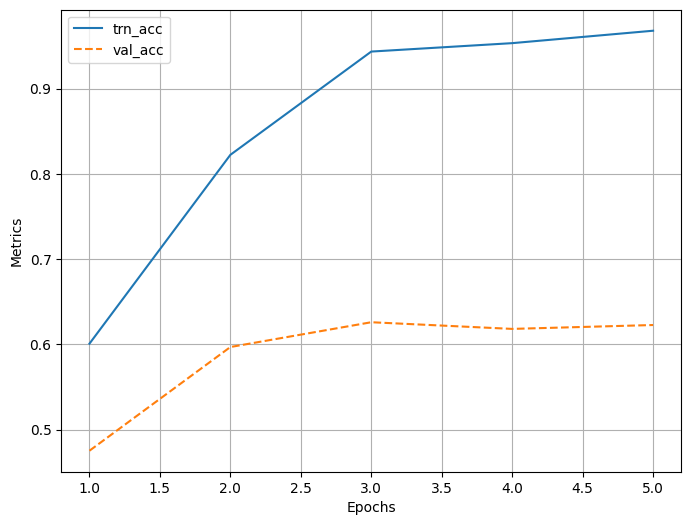

In [25]:
log.plot_epochs('trn_acc,val_acc'.split(','))

<h2 style="background-color:#EEEEEE; color:#222831; text-align:left; font-family:Georgia">NMS (Non-max suppression)</h2>
- Discards boxes without high probabilities of objects. Squshes duplicated boxes that share more than 0.05 overlap. Boxes with highest confidence chosen.

In [26]:
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)  #Concatenates the given sequence of seq tensors in the given dimension
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        print("Shape of probs", np.shape(probs))
        print("Shape of deltas", np.shape(deltas))
        probs = torch.nn.functional.softmax(probs, -1)  # probability is put between 0 and 1 by doing a softmax
        confs, clss = torch.max(probs, -1) #-1 is the dimension in which the max (reduction) must happen -> confs tells me the confidence and clss tells me the class where it has found the max probs
        print("Shape of confs", np.shape(confs))
        print("Shape of clss", np.shape(clss))
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        # condition that even after nms, many ixs come for the bbox
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)  # index
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title('Predicted object: ' + target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Shape of probs
torch.Size([45, 3])

Shape of deltas
torch.Size([45, 4])

Shape of confs
torch.Size([45])

Shape of clss
torch.Size([45])

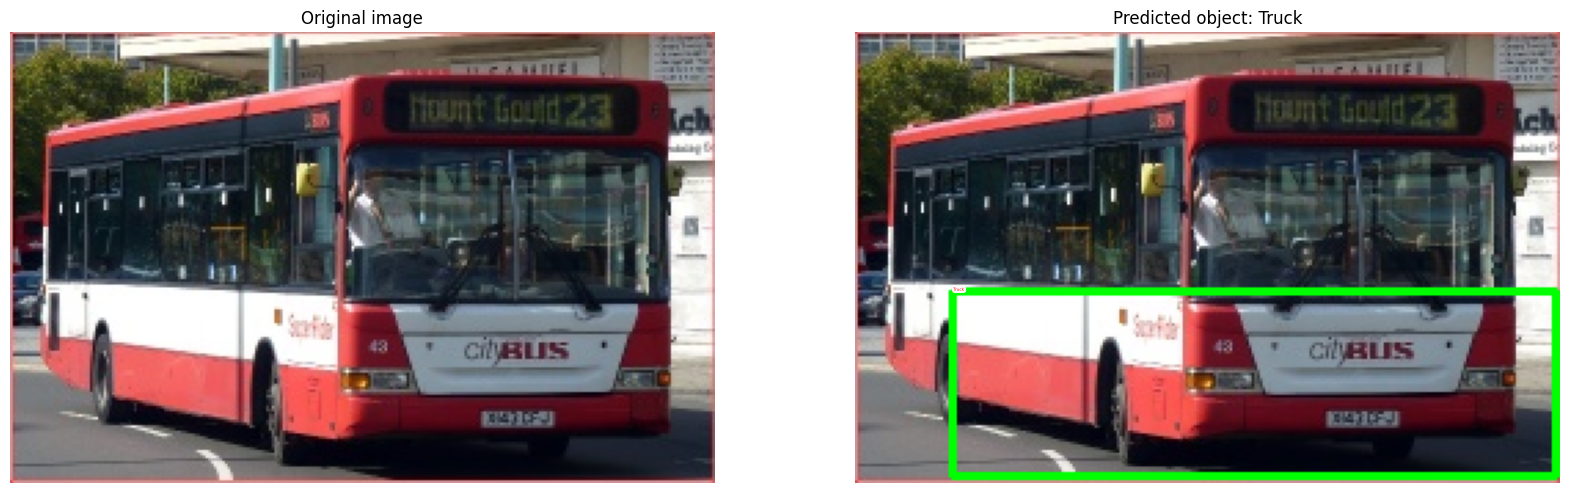

((35, 94, 254, 161), 'Truck', 0.7129184)

In [27]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[6]
test_predictions(fpath)